# Efficient COCO Dataset Generator

This notebook was Inspired by [this](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data?scriptVersionId=77658860) great notebook. I made a few improvements in the `rle2mask` code to make it more efficient and used the functions provided in `pycocotools` to generate the json file. This results in massive reduction of compute time and dataset size.

What seemed at first to be a trivial task was a bit difficult as the RLE encoding used by COCO is very different from the encoding used in this comp.  

The comp encoding is rowise and every `odd` index represent the absolute begining of the mask. In the other hand, coco format expects it to be encoded by columns and the `odd` indexes are relative to the last end of the mask.

I couldn't find a trivial way to convert from those two formats without decoding the rle to mask, so the workflow is as folows:

1. Decode rle (competition) to binary mask
1. Encode the binary mask to rle (coco) using `pycocotools`
1. Save to `.json`

In [2]:
# !pip install -Uqqq pycocotools
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [59]:
%config Completer.use_jedi = False # use autocompletion

AttributeError: Completer

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

## Loading the train dataframe

In [4]:
df = pd.read_csv('sartorius-cell-instance-segmentation/train.csv')
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

## Function that decodes rle (for this comp) to a binary mask

In [5]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

## Minor Sanity Check

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


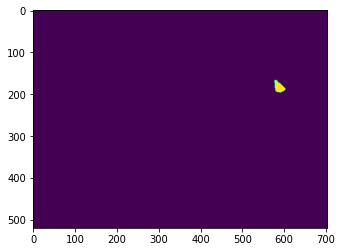

In [6]:
rle = df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

## Function that builds the .json file

In [7]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
        mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
        return annotation
    
def coco_structure(df, workers = 4):
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

## Running for the whole DF and saving it as a .json file

In [8]:
import json,itertools

np.random.seed(42)

def split_df(df, thresh):
    all_ids = df.id.unique()
    np.random.shuffle(all_ids)
    thresh = int(all_ids.shape[0]*0.8) + 1

    train_df = df[df.id.isin(all_ids[:thresh])]
    val_df = df[df.id.isin(all_ids[thresh:])]

    train = coco_structure(train_df)
    val = coco_structure(val_df)
    
    return train, val

df_c0 = 

  0%|          | 0/61792 [00:00<?, ?it/s]

  0%|          | 0/11793 [00:00<?, ?it/s]

In [9]:
with open('sartorius-cell-instance-segmentation-coco/annotations_train.json', 'w+', encoding='utf-8') as f:
    json.dump(train, f, ensure_ascii=True, indent=4)
with open('sartorius-cell-instance-segmentation-coco/annotations_val.json', 'w+', encoding='utf-8') as f:
    json.dump(val, f, ensure_ascii=True, indent=4)

# Sanity check

In [2]:
dataDir=Path('sartorius-cell-instance-segmentation')
annFile = Path('sartorius-cell-instance-segmentation-coco/annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [11]:
# imgs = coco.loadImgs(imgIds[-3:])
# _,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
# for img, ax in zip(imgs, axs):
#     I = Image.open(dataDir/img['file_name'])
#     annIds = coco.getAnnIds(imgIds=[img['id']])
#     anns = coco.loadAnns(annIds)
#     ax[0].imshow(I)
#     ax[1].imshow(I)
#     plt.sca(ax[1])
#     coco.showAnns(anns, draw_bbox=True)

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [3]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[11/17 10:04:50 d2.data.datasets.coco]: Loaded 485 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json


### Display a sample file to check the data is loaded correctly

In [13]:
# d = train_ds[42]
# img = cv2.imread(d["file_name"])
# visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
# out = visualizer.draw_dataset_dict(d)
# plt.figure(figsize = (20,15))
# plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [4]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks
    

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 10000 iterations.

In [5]:
%%time

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

# # Mode for flipping images used in data augmentation during training
# # choose one of ["horizontal, "vertical", "none"]
# cfg.INPUT.RANDOM_FLIP = "horizontal"
# # `True` if cropping is used for data augmentation during training
# cfg.INPUT.CROP = CN({"ENABLED": False})
# # Cropping type. See documentation of `detectron2.data.transforms.RandomCrop` for explanation.
# cfg.INPUT.CROP.TYPE = "relative_range"
# # Size of crop in range (0, 1] if CROP.TYPE is "relative" or "relative_range" and in number of
# # pixels if CROP.TYPE is "absolute"
# cfg.INPUT.CROP.SIZE = [0.9, 0.9]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/17 10:04:55 d2.data.datasets.coco]: Loaded 485 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[11/17 10:05:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size

[11/17 10:05:15 d2.data.datasets.coco]: Loaded 485 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[11/17 10:05:15 d2.data.build]: Removed 0 images with no usable annotations. 485 images left.
[11/17 10:05:15 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   shsy5y   | 44235        |    cort    | 8211         |   astro    | 9346         |
|            |              |            |              |            |              |
|   total    | 61792        |            |              |            |              |
[11/17 10:05:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/17 10:05:15 d2.data.build]: Using t

model_final_a3ec72.pkl: 254MB [02:13, 1.90MB/s]                                 
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model 

[11/17 10:07:30 d2.engine.train_loop]: Starting training from iteration 0


/home/alex/anaconda3/envs/sartorius/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/17 10:07:54 d2.utils.events]:  eta: 1:57:15  iter: 19  total_loss: 6.817  loss_cls: 1.339  loss_box_reg: 0.3875  loss_mask: 0.6923  loss_rpn_cls: 3.889  loss_rpn_loc: 0.327  time: 0.8474  data_time: 0.2109  lr: 9.9905e-06  max_mem: 4823M
[11/17 10:08:13 d2.utils.events]:  eta: 1:55:30  iter: 39  total_loss: 3.327  loss_cls: 1.262  loss_box_reg: 0.3658  loss_mask: 0.6901  loss_rpn_cls: 0.6023  loss_rpn_loc: 0.3505  time: 0.9052  data_time: 0.2774  lr: 1.998e-05  max_mem: 5406M
[11/17 10:08:31 d2.utils.events]:  eta: 1:54:08  iter: 59  total_loss: 2.862  loss_cls: 1.056  loss_box_reg: 0.4389  loss_mask: 0.6852  loss_rpn_cls: 0.3878  loss_rpn_loc: 0.3172  time: 0.9060  data_time: 0.2469  lr: 2.997e-05  max_mem: 5423M
[11/17 10:08:47 d2.utils.events]:  eta: 1:52:55  iter: 79  total_loss: 2.596  loss_cls: 0.8319  loss_box_reg: 0.4804  loss_mask: 0.6717  loss_rpn_cls: 0.2929  loss_rpn_loc: 0.2932  time: 0.8730  data_time: 0.1067  lr: 3.9961e-05  max_mem: 5958M
[11/17 10:09:04 d2.utils.ev

[11/17 10:14:36 d2.utils.events]:  eta: 1:52:21  iter: 419  total_loss: 1.952  loss_cls: 0.4721  loss_box_reg: 0.6717  loss_mask: 0.3662  loss_rpn_cls: 0.1335  loss_rpn_loc: 0.2461  time: 0.9491  data_time: 0.0907  lr: 0.00020979  max_mem: 5968M
[11/17 10:14:51 d2.utils.events]:  eta: 1:52:05  iter: 439  total_loss: 1.882  loss_cls: 0.4933  loss_box_reg: 0.6402  loss_mask: 0.3844  loss_rpn_cls: 0.1134  loss_rpn_loc: 0.2272  time: 0.9413  data_time: 0.0987  lr: 0.00021978  max_mem: 5968M
[11/17 10:15:08 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 10:15:13 d2.utils.events]:  eta: 1:51:51  iter: 459  total_loss: 1.876  loss_cls: 0.4581  loss_box_reg: 0.6261  loss_mask: 0.3842  loss_rpn_cls: 0.1255  loss_rpn_loc: 0.2623  time: 0.9466  data_time: 0.2879  lr: 0.00022977  max_mem: 5968M
[11/17 10:15:33 d2.utils.events]:  eta: 1:51:36  iter: 479  total_loss: 1.731  loss_cls: 0.4393  loss_box_reg: 0.6014  loss_mask: 0.36

[11/17 10:20:09 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/17 10:20:09 d2.evaluation.testing]: copypaste: MaP IoU=0.2517547882759631
[11/17 10:20:12 d2.engine.hooks]: Saved best model as latest eval score for MaP IoU is 0.25175, better than last best score 0.19609 @ iteration 483.
[11/17 10:20:23 d2.utils.events]:  eta: 1:49:21  iter: 739  total_loss: 1.794  loss_cls: 0.4545  loss_box_reg: 0.6096  loss_mask: 0.341  loss_rpn_cls: 0.1195  loss_rpn_loc: 0.236  time: 0.9421  data_time: 0.0906  lr: 0.00036963  max_mem: 6123M
[11/17 10:20:29 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 10:20:45 d2.utils.events]:  eta: 1:49:18  iter: 759  total_loss: 1.618  loss_cls: 0.3946  loss_box_reg: 0.579  loss_mask: 0.3506  loss_rpn_cls: 0.1259  loss_rpn_loc: 0.2403  time: 0.9460  data_time: 0.2621  lr: 0.00037962  max_mem: 6123M
[11/17 10:21:02 d2.utils.events]:  eta: 1:49:04  iter: 779  total_l

[11/17 10:27:19 d2.utils.events]:  eta: 1:45:53  iter: 1159  total_loss: 1.54  loss_cls: 0.3649  loss_box_reg: 0.5519  loss_mask: 0.3219  loss_rpn_cls: 0.1167  loss_rpn_loc: 0.2163  time: 0.9396  data_time: 0.2425  lr: 0.0005  max_mem: 6310M
[11/17 10:27:39 d2.utils.events]:  eta: 1:45:47  iter: 1179  total_loss: 1.619  loss_cls: 0.3819  loss_box_reg: 0.5518  loss_mask: 0.3345  loss_rpn_cls: 0.1105  loss_rpn_loc: 0.2232  time: 0.9399  data_time: 0.2664  lr: 0.0005  max_mem: 6310M
[11/17 10:27:57 d2.utils.events]:  eta: 1:45:41  iter: 1199  total_loss: 1.647  loss_cls: 0.3995  loss_box_reg: 0.6211  loss_mask: 0.3174  loss_rpn_cls: 0.104  loss_rpn_loc: 0.229  time: 0.9393  data_time: 0.1877  lr: 0.0005  max_mem: 6310M
[11/17 10:28:06 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[11/17 10:28:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800,

[11/17 10:32:40 d2.evaluation.testing]: copypaste: MaP IoU=0.2849097129084435
[11/17 10:32:42 d2.engine.hooks]: Saved best model as latest eval score for MaP IoU is 0.28491, better than last best score 0.27060 @ iteration 1209.
[11/17 10:32:49 d2.utils.events]:  eta: 1:42:18  iter: 1459  total_loss: 1.572  loss_cls: 0.3458  loss_box_reg: 0.5355  loss_mask: 0.3205  loss_rpn_cls: 0.09966  loss_rpn_loc: 0.2302  time: 0.9407  data_time: 0.2005  lr: 0.0005  max_mem: 6426M
[11/17 10:33:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 10:33:09 d2.utils.events]:  eta: 1:42:00  iter: 1479  total_loss: 1.665  loss_cls: 0.3709  loss_box_reg: 0.5741  loss_mask: 0.336  loss_rpn_cls: 0.08506  loss_rpn_loc: 0.2158  time: 0.9411  data_time: 0.1942  lr: 0.0005  max_mem: 6426M
[11/17 10:33:27 d2.utils.events]:  eta: 1:41:41  iter: 1499  total_loss: 1.568  loss_cls: 0.403  loss_box_reg: 0.5543  loss_mask: 0.3147  loss_rpn_cls: 0.110

[11/17 10:39:35 d2.utils.events]:  eta: 1:37:46  iter: 1859  total_loss: 1.556  loss_cls: 0.3488  loss_box_reg: 0.5506  loss_mask: 0.32  loss_rpn_cls: 0.09237  loss_rpn_loc: 0.195  time: 0.9447  data_time: 0.3281  lr: 0.0005  max_mem: 6426M
[11/17 10:39:49 d2.utils.events]:  eta: 1:37:16  iter: 1879  total_loss: 1.535  loss_cls: 0.3598  loss_box_reg: 0.5657  loss_mask: 0.3351  loss_rpn_cls: 0.09031  loss_rpn_loc: 0.1925  time: 0.9423  data_time: 0.0509  lr: 0.0005  max_mem: 6426M
[11/17 10:40:08 d2.utils.events]:  eta: 1:37:01  iter: 1899  total_loss: 1.496  loss_cls: 0.3654  loss_box_reg: 0.5099  loss_mask: 0.3166  loss_rpn_cls: 0.08074  loss_rpn_loc: 0.2201  time: 0.9422  data_time: 0.2355  lr: 0.0005  max_mem: 6426M
[11/17 10:40:29 d2.utils.events]:  eta: 1:36:49  iter: 1919  total_loss: 1.624  loss_cls: 0.4433  loss_box_reg: 0.5366  loss_mask: 0.3121  loss_rpn_cls: 0.1279  loss_rpn_loc: 0.2128  time: 0.9432  data_time: 0.3431  lr: 0.0005  max_mem: 6426M
[11/17 10:40:41 d2.data.data

[11/17 10:45:09 d2.evaluation.testing]: copypaste: MaP IoU=0.282408389615538
[11/17 10:45:09 d2.engine.hooks]: Not saving as latest eval score for MaP IoU is 0.28241, not better than best score 0.28597 @ iteration 1935.
[11/17 10:45:10 d2.utils.events]:  eta: 1:33:23  iter: 2179  total_loss: 1.633  loss_cls: 0.4005  loss_box_reg: 0.5886  loss_mask: 0.3209  loss_rpn_cls: 0.1157  loss_rpn_loc: 0.2197  time: 0.9394  data_time: 0.3117  lr: 0.0005  max_mem: 6426M
[11/17 10:45:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 10:45:29 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 10:45:32 d2.utils.events]:  eta: 1:33:03  iter: 2199  total_loss: 1.507  loss_cls: 0.3633  loss_box_reg: 0.5559  loss_mask: 0.3284  loss_rpn_cls: 0.1034  loss_rpn_loc: 0.2136  time: 0.9409  data_time: 0.1967  lr: 0.0005  max_mem: 6426M
[11/17 10:45:51 d2.utils.events]:  eta

[11/17 10:51:40 d2.utils.events]:  eta: 1:28:59  iter: 2539  total_loss: 1.54  loss_cls: 0.3629  loss_box_reg: 0.5217  loss_mask: 0.3043  loss_rpn_cls: 0.1153  loss_rpn_loc: 0.1906  time: 0.9502  data_time: 0.2153  lr: 0.0005  max_mem: 6426M
[11/17 10:51:55 d2.utils.events]:  eta: 1:28:39  iter: 2559  total_loss: 1.548  loss_cls: 0.3279  loss_box_reg: 0.5741  loss_mask: 0.3117  loss_rpn_cls: 0.09319  loss_rpn_loc: 0.2058  time: 0.9485  data_time: 0.0570  lr: 0.0005  max_mem: 6426M
[11/17 10:52:15 d2.utils.events]:  eta: 1:28:33  iter: 2579  total_loss: 1.619  loss_cls: 0.3768  loss_box_reg: 0.5768  loss_mask: 0.3109  loss_rpn_cls: 0.1114  loss_rpn_loc: 0.2233  time: 0.9492  data_time: 0.3047  lr: 0.0005  max_mem: 6426M
[11/17 10:52:34 d2.utils.events]:  eta: 1:28:39  iter: 2599  total_loss: 1.617  loss_cls: 0.3961  loss_box_reg: 0.5187  loss_mask: 0.3187  loss_rpn_cls: 0.08639  loss_rpn_loc: 0.2298  time: 0.9491  data_time: 0.2331  lr: 0.0005  max_mem: 6426M
[11/17 10:52:53 d2.utils.ev

[11/17 10:57:41 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0008 s/iter. Inference: 0.1568 s/iter. Eval: 0.0186 s/iter. Total: 0.1762 s/iter. ETA=0:00:19
[11/17 10:57:47 d2.evaluation.evaluator]: Inference done 39/121. Dataloading: 0.0009 s/iter. Inference: 0.1591 s/iter. Eval: 0.0203 s/iter. Total: 0.1805 s/iter. ETA=0:00:14
[11/17 10:57:52 d2.evaluation.evaluator]: Inference done 69/121. Dataloading: 0.0010 s/iter. Inference: 0.1562 s/iter. Eval: 0.0185 s/iter. Total: 0.1756 s/iter. ETA=0:00:09
[11/17 10:57:57 d2.evaluation.evaluator]: Inference done 99/121. Dataloading: 0.0010 s/iter. Inference: 0.1545 s/iter. Eval: 0.0176 s/iter. Total: 0.1731 s/iter. ETA=0:00:03
[11/17 10:58:00 d2.evaluation.evaluator]: Total inference time: 0:00:20.097991 (0.173259 s / iter per device, on 1 devices)
[11/17 10:58:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.154317 s / iter per device, on 1 devices)
[11/17 10:58:00 d2.engine.defaults]: Evaluation re

[11/17 11:04:07 d2.utils.events]:  eta: 1:20:15  iter: 3259  total_loss: 1.494  loss_cls: 0.3424  loss_box_reg: 0.5611  loss_mask: 0.308  loss_rpn_cls: 0.05473  loss_rpn_loc: 0.1876  time: 0.9487  data_time: 0.0359  lr: 0.0005  max_mem: 6426M
[11/17 11:04:27 d2.utils.events]:  eta: 1:20:00  iter: 3279  total_loss: 1.554  loss_cls: 0.3666  loss_box_reg: 0.5367  loss_mask: 0.3128  loss_rpn_cls: 0.09799  loss_rpn_loc: 0.2154  time: 0.9492  data_time: 0.3136  lr: 0.0005  max_mem: 6426M
[11/17 11:04:48 d2.utils.events]:  eta: 1:19:52  iter: 3299  total_loss: 1.534  loss_cls: 0.366  loss_box_reg: 0.5299  loss_mask: 0.3147  loss_rpn_cls: 0.099  loss_rpn_loc: 0.2432  time: 0.9496  data_time: 0.3525  lr: 0.0005  max_mem: 6426M
[11/17 11:05:05 d2.utils.events]:  eta: 1:19:40  iter: 3319  total_loss: 1.482  loss_cls: 0.3653  loss_box_reg: 0.5441  loss_mask: 0.3177  loss_rpn_cls: 0.08898  loss_rpn_loc: 0.2157  time: 0.9493  data_time: 0.1760  lr: 0.0005  max_mem: 6426M
[11/17 11:05:27 d2.utils.eve

[11/17 11:10:24 d2.evaluation.evaluator]: Inference done 41/121. Dataloading: 0.0010 s/iter. Inference: 0.1509 s/iter. Eval: 0.0167 s/iter. Total: 0.1686 s/iter. ETA=0:00:13
[11/17 11:10:29 d2.evaluation.evaluator]: Inference done 72/121. Dataloading: 0.0010 s/iter. Inference: 0.1506 s/iter. Eval: 0.0159 s/iter. Total: 0.1675 s/iter. ETA=0:00:08
[11/17 11:10:34 d2.evaluation.evaluator]: Inference done 103/121. Dataloading: 0.0010 s/iter. Inference: 0.1502 s/iter. Eval: 0.0151 s/iter. Total: 0.1664 s/iter. ETA=0:00:02
[11/17 11:10:37 d2.evaluation.evaluator]: Total inference time: 0:00:19.406447 (0.167297 s / iter per device, on 1 devices)
[11/17 11:10:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.150597 s / iter per device, on 1 devices)
[11/17 11:10:37 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/17 11:10:37 d2.evaluation.testing]: copypaste: MaP IoU=0.2878254435258959
[11/17 11:10:37 d2.engine.hooks]: Not saving as latest e

[11/17 11:16:28 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:16:37 d2.utils.events]:  eta: 1:11:42  iter: 3999  total_loss: 1.464  loss_cls: 0.3473  loss_box_reg: 0.5183  loss_mask: 0.3035  loss_rpn_cls: 0.05421  loss_rpn_loc: 0.2101  time: 0.9449  data_time: 0.1559  lr: 0.0005  max_mem: 6557M
[11/17 11:16:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:16:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:17:03 d2.utils.events]:  eta: 1:11:32  iter: 4019  total_loss: 1.515  loss_cls: 0.3618  loss_box_reg: 0.5453  loss_mask: 0.2955  loss_rpn_cls: 0.1093  loss_rpn_loc: 0.2138  time: 0.9467  data_time: 0.3833  lr: 0.0005  max_mem: 6557M
[11/17 11:17:20 d2.utils.events]:  eta: 1:11:13  iter: 4039  total_loss: 1.494  loss_cls: 0.3461  loss_box_reg: 0.5178  loss_mask

[11/17 11:22:36 d2.evaluation.evaluator]: Start inference on 121 batches
[11/17 11:22:38 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0008 s/iter. Inference: 0.1526 s/iter. Eval: 0.0176 s/iter. Total: 0.1710 s/iter. ETA=0:00:18
[11/17 11:22:43 d2.evaluation.evaluator]: Inference done 40/121. Dataloading: 0.0009 s/iter. Inference: 0.1541 s/iter. Eval: 0.0205 s/iter. Total: 0.1755 s/iter. ETA=0:00:14
[11/17 11:22:48 d2.evaluation.evaluator]: Inference done 70/121. Dataloading: 0.0010 s/iter. Inference: 0.1537 s/iter. Eval: 0.0187 s/iter. Total: 0.1734 s/iter. ETA=0:00:08
[11/17 11:22:53 d2.evaluation.evaluator]: Inference done 100/121. Dataloading: 0.0010 s/iter. Inference: 0.1533 s/iter. Eval: 0.0180 s/iter. Total: 0.1723 s/iter. ETA=0:00:03
[11/17 11:22:57 d2.evaluation.evaluator]: Total inference time: 0:00:20.110974 (0.173370 s / iter per device, on 1 devices)
[11/17 11:22:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.153960 s / iter pe

[11/17 11:28:23 d2.utils.events]:  eta: 1:03:15  iter: 4679  total_loss: 1.406  loss_cls: 0.3308  loss_box_reg: 0.5077  loss_mask: 0.3102  loss_rpn_cls: 0.08925  loss_rpn_loc: 0.2007  time: 0.9431  data_time: 0.2780  lr: 0.0005  max_mem: 6557M
[11/17 11:28:45 d2.utils.events]:  eta: 1:03:02  iter: 4699  total_loss: 1.5  loss_cls: 0.3714  loss_box_reg: 0.5  loss_mask: 0.2935  loss_rpn_cls: 0.08922  loss_rpn_loc: 0.2195  time: 0.9437  data_time: 0.3781  lr: 0.0005  max_mem: 6557M
[11/17 11:28:50 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:29:06 d2.utils.events]:  eta: 1:02:47  iter: 4719  total_loss: 1.507  loss_cls: 0.334  loss_box_reg: 0.5184  loss_mask: 0.3093  loss_rpn_cls: 0.08665  loss_rpn_loc: 0.2104  time: 0.9441  data_time: 0.2497  lr: 0.0005  max_mem: 6557M
[11/17 11:29:26 d2.utils.events]:  eta: 1:02:31  iter: 4739  total_loss: 1.505  loss_cls: 0.3764  loss_box_reg: 0.5338  loss_mask: 0.3158  loss_rp

[11/17 11:35:11 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[11/17 11:35:11 d2.data.common]: Serialized dataset takes 1.35 MiB
[11/17 11:35:11 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[11/17 11:35:11 d2.evaluation.evaluator]: Start inference on 121 batches
[11/17 11:35:13 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0008 s/iter. Inference: 0.1524 s/iter. Eval: 0.0172 s/iter. Total: 0.1704 s/iter. ETA=0:00:18
[11/17 11:35:18 d2.evaluation.evaluator]: Inference done 40/121. Dataloading: 0.0009 s/iter. Inference: 0.1544 s/iter. Eval: 0.0204 s/iter. Total: 0.1758 s/iter. ETA=0:00:14
[11/17 11:35:23 d2.evaluation.evaluator]: Inference done 69/121. Dataloading: 0.0010 s/iter. Inference: 0.1541 s/iter. Eval: 0.0193 s/iter. Total: 0.1743 s/iter. ETA=0:00:09
[11/17 11:35:28 d2.evaluation.evaluator]: Inference done 98/121. Dataloading: 0.0010 s/iter.

[11/17 11:40:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:41:00 d2.utils.events]:  eta: 0:54:41  iter: 5399  total_loss: 1.411  loss_cls: 0.3106  loss_box_reg: 0.517  loss_mask: 0.309  loss_rpn_cls: 0.08612  loss_rpn_loc: 0.217  time: 0.9447  data_time: 0.2760  lr: 0.0005  max_mem: 6557M
[11/17 11:41:19 d2.utils.events]:  eta: 0:54:39  iter: 5419  total_loss: 1.499  loss_cls: 0.3598  loss_box_reg: 0.5239  loss_mask: 0.3019  loss_rpn_cls: 0.07594  loss_rpn_loc: 0.1894  time: 0.9445  data_time: 0.1982  lr: 0.0005  max_mem: 6557M
[11/17 11:41:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:41:39 d2.utils.events]:  eta: 0:54:14  iter: 5439  total_loss: 1.393  loss_cls: 0.3431  loss_box_reg: 0.5249  loss_mask: 0.2928  loss_rpn_cls: 0.06903  loss_rpn_loc: 0.2108  time: 0.9449  data_time: 0.2584  lr: 0.0005  max_mem: 6557M
[11/17 11:41:53

[11/17 11:47:37 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[11/17 11:47:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/17 11:47:37 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[11/17 11:47:37 d2.data.common]: Serialized dataset takes 1.35 MiB
[11/17 11:47:37 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[11/17 11:47:37 d2.evaluation.evaluator]: Start inference on 121 batches
[11/17 11:47:39 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0007 s/iter. Inference: 0.1519 s/iter. Eval: 0.0175 s/iter. Total: 0.1701 s/iter. ETA=0:00:18
[11/17 11:47:44 d2.evaluation.evaluator]: Inference done 40/121. Dataloading: 0.0009 s/iter. Inference: 0.1548 s/iter. E

[11/17 11:53:11 d2.utils.events]:  eta: 0:46:22  iter: 6119  total_loss: 1.598  loss_cls: 0.3753  loss_box_reg: 0.5058  loss_mask: 0.3172  loss_rpn_cls: 0.106  loss_rpn_loc: 0.225  time: 0.9419  data_time: 0.3353  lr: 0.0005  max_mem: 6557M
[11/17 11:53:30 d2.utils.events]:  eta: 0:46:08  iter: 6139  total_loss: 1.522  loss_cls: 0.3665  loss_box_reg: 0.5063  loss_mask: 0.3278  loss_rpn_cls: 0.07536  loss_rpn_loc: 0.2253  time: 0.9420  data_time: 0.2721  lr: 0.0005  max_mem: 6557M
[11/17 11:53:51 d2.utils.events]:  eta: 0:45:53  iter: 6159  total_loss: 1.405  loss_cls: 0.338  loss_box_reg: 0.5113  loss_mask: 0.2986  loss_rpn_cls: 0.0854  loss_rpn_loc: 0.1932  time: 0.9422  data_time: 0.3149  lr: 0.0005  max_mem: 6557M
[11/17 11:54:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:54:06 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 11:54:16 d

[11/17 11:59:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/17 11:59:58 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[11/17 11:59:58 d2.data.common]: Serialized dataset takes 1.35 MiB
[11/17 11:59:58 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json
[11/17 11:59:58 d2.evaluation.evaluator]: Start inference on 121 batches
[11/17 12:00:00 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0008 s/iter. Inference: 0.1508 s/iter. Eval: 0.0168 s/iter. Total: 0.1684 s/iter. ETA=0:00:18
[11/17 12:00:05 d2.evaluation.evaluator]: Inference done 40/121. Dataloading: 0.0010 s/iter. Inference: 0.1542 s/iter. Eval: 0.0205 s/iter. Total: 0.1757 s/iter. ETA=0:00:14
[11/17 12:00:10 d2.evaluation.evaluator]: Inference done 70/121. Dataloading: 0.0010 s/

[11/17 12:05:36 d2.utils.events]:  eta: 0:37:15  iter: 6859  total_loss: 1.442  loss_cls: 0.3454  loss_box_reg: 0.5378  loss_mask: 0.3038  loss_rpn_cls: 0.06081  loss_rpn_loc: 0.1838  time: 0.9395  data_time: 0.0411  lr: 0.0005  max_mem: 6557M
[11/17 12:05:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:05:56 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:06:02 d2.utils.events]:  eta: 0:37:03  iter: 6879  total_loss: 1.546  loss_cls: 0.3887  loss_box_reg: 0.5044  loss_mask: 0.3189  loss_rpn_cls: 0.09118  loss_rpn_loc: 0.2216  time: 0.9405  data_time: 0.3907  lr: 0.0005  max_mem: 6557M
[11/17 12:06:17 d2.utils.events]:  eta: 0:36:48  iter: 6899  total_loss: 1.378  loss_cls: 0.3434  loss_box_reg: 0.5069  loss_mask: 0.2766  loss_rpn_cls: 0.07789  loss_rpn_loc: 0.1956  time: 0.9400  data_time: 0.0841  lr: 0.0005  max_mem: 6557M
[11/17 12:06

[11/17 12:12:20 d2.evaluation.evaluator]: Start inference on 121 batches
[11/17 12:12:22 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0008 s/iter. Inference: 0.1506 s/iter. Eval: 0.0167 s/iter. Total: 0.1681 s/iter. ETA=0:00:18
[11/17 12:12:27 d2.evaluation.evaluator]: Inference done 40/121. Dataloading: 0.0009 s/iter. Inference: 0.1535 s/iter. Eval: 0.0204 s/iter. Total: 0.1748 s/iter. ETA=0:00:14
[11/17 12:12:32 d2.evaluation.evaluator]: Inference done 70/121. Dataloading: 0.0009 s/iter. Inference: 0.1536 s/iter. Eval: 0.0186 s/iter. Total: 0.1732 s/iter. ETA=0:00:08
[11/17 12:12:37 d2.evaluation.evaluator]: Inference done 100/121. Dataloading: 0.0010 s/iter. Inference: 0.1534 s/iter. Eval: 0.0180 s/iter. Total: 0.1724 s/iter. ETA=0:00:03
[11/17 12:12:41 d2.evaluation.evaluator]: Total inference time: 0:00:20.123438 (0.173478 s / iter per device, on 1 devices)
[11/17 12:12:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.153916 s / iter pe

[11/17 12:18:24 d2.utils.events]:  eta: 0:28:20  iter: 7619  total_loss: 1.407  loss_cls: 0.3055  loss_box_reg: 0.5162  loss_mask: 0.3009  loss_rpn_cls: 0.06421  loss_rpn_loc: 0.1895  time: 0.9377  data_time: 0.1300  lr: 0.0005  max_mem: 6557M
[11/17 12:18:36 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:18:44 d2.utils.events]:  eta: 0:28:06  iter: 7639  total_loss: 1.44  loss_cls: 0.3174  loss_box_reg: 0.5208  loss_mask: 0.3293  loss_rpn_cls: 0.06955  loss_rpn_loc: 0.2117  time: 0.9378  data_time: 0.1924  lr: 0.0005  max_mem: 6557M
[11/17 12:19:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:19:08 d2.utils.events]:  eta: 0:27:50  iter: 7659  total_loss: 1.468  loss_cls: 0.3326  loss_box_reg: 0.5244  loss_mask: 0.3398  loss_rpn_cls: 0.07008  loss_rpn_loc: 0.1994  time: 0.9385  data_time: 0.3698  lr: 0.0005  max_mem: 6557M
[11/17 12:19:

[11/17 12:24:42 d2.evaluation.evaluator]: Inference done 39/121. Dataloading: 0.0009 s/iter. Inference: 0.1559 s/iter. Eval: 0.0201 s/iter. Total: 0.1770 s/iter. ETA=0:00:14
[11/17 12:24:47 d2.evaluation.evaluator]: Inference done 69/121. Dataloading: 0.0009 s/iter. Inference: 0.1539 s/iter. Eval: 0.0181 s/iter. Total: 0.1730 s/iter. ETA=0:00:08
[11/17 12:24:52 d2.evaluation.evaluator]: Inference done 99/121. Dataloading: 0.0009 s/iter. Inference: 0.1531 s/iter. Eval: 0.0174 s/iter. Total: 0.1715 s/iter. ETA=0:00:03
[11/17 12:24:56 d2.evaluation.evaluator]: Total inference time: 0:00:19.982069 (0.172259 s / iter per device, on 1 devices)
[11/17 12:24:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.153596 s / iter per device, on 1 devices)
[11/17 12:24:56 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/17 12:24:56 d2.evaluation.testing]: copypaste: MaP IoU=0.3020949318494929
[11/17 12:24:56 d2.engine.hooks]: Not saving as latest ev

[11/17 12:31:36 d2.utils.events]:  eta: 0:19:10  iter: 8399  total_loss: 1.43  loss_cls: 0.3336  loss_box_reg: 0.5095  loss_mask: 0.298  loss_rpn_cls: 0.06292  loss_rpn_loc: 0.2051  time: 0.9371  data_time: 0.1938  lr: 0.0005  max_mem: 6557M
[11/17 12:31:55 d2.utils.events]:  eta: 0:18:56  iter: 8419  total_loss: 1.454  loss_cls: 0.3178  loss_box_reg: 0.5175  loss_mask: 0.307  loss_rpn_cls: 0.08138  loss_rpn_loc: 0.203  time: 0.9371  data_time: 0.2350  lr: 0.0005  max_mem: 6557M
[11/17 12:32:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:32:20 d2.utils.events]:  eta: 0:18:42  iter: 8439  total_loss: 1.352  loss_cls: 0.2683  loss_box_reg: 0.4754  loss_mask: 0.3095  loss_rpn_cls: 0.06265  loss_rpn_loc: 0.1906  time: 0.9379  data_time: 0.4219  lr: 0.0005  max_mem: 6557M
[11/17 12:32:37 d2.utils.events]:  eta: 0:18:26  iter: 8459  total_loss: 1.333  loss_cls: 0.3027  loss_box_reg: 0.4433  loss_mask: 0.2976  loss_

[11/17 12:37:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.152716 s / iter per device, on 1 devices)
[11/17 12:37:17 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/17 12:37:17 d2.evaluation.testing]: copypaste: MaP IoU=0.30338431913970626
[11/17 12:37:17 d2.engine.hooks]: Not saving as latest eval score for MaP IoU is 0.30338, not better than best score 0.31065 @ iteration 7501.
[11/17 12:37:23 d2.utils.events]:  eta: 0:15:24  iter: 8719  total_loss: 1.458  loss_cls: 0.3084  loss_box_reg: 0.5168  loss_mask: 0.2918  loss_rpn_cls: 0.08291  loss_rpn_loc: 0.1988  time: 0.9376  data_time: 0.1275  lr: 0.0005  max_mem: 6557M
[11/17 12:37:42 d2.utils.events]:  eta: 0:15:10  iter: 8739  total_loss: 1.337  loss_cls: 0.2654  loss_box_reg: 0.4845  loss_mask: 0.3039  loss_rpn_cls: 0.0665  loss_rpn_loc: 0.1808  time: 0.9376  data_time: 0.2469  lr: 0.0005  max_mem: 6557M
[11/17 12:38:00 d2.utils.events]:  eta: 0:14:56  iter: 8759  total_loss:

[11/17 12:44:07 d2.utils.events]:  eta: 0:10:36  iter: 9119  total_loss: 1.463  loss_cls: 0.3379  loss_box_reg: 0.5164  loss_mask: 0.2861  loss_rpn_cls: 0.06645  loss_rpn_loc: 0.1724  time: 0.9384  data_time: 0.0783  lr: 0.0005  max_mem: 6557M
[11/17 12:44:27 d2.utils.events]:  eta: 0:10:21  iter: 9139  total_loss: 1.388  loss_cls: 0.3387  loss_box_reg: 0.476  loss_mask: 0.3023  loss_rpn_cls: 0.07674  loss_rpn_loc: 0.1987  time: 0.9385  data_time: 0.2907  lr: 0.0005  max_mem: 6557M
[11/17 12:44:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:44:48 d2.utils.events]:  eta: 0:10:06  iter: 9159  total_loss: 1.461  loss_cls: 0.3737  loss_box_reg: 0.5147  loss_mask: 0.3016  loss_rpn_cls: 0.07541  loss_rpn_loc: 0.2058  time: 0.9387  data_time: 0.2265  lr: 0.0005  max_mem: 6557M
[11/17 12:45:07 d2.utils.events]:  eta: 0:09:52  iter: 9179  total_loss: 1.34  loss_cls: 0.287  loss_box_reg: 0.4953  loss_mask: 0.3081  loss

[11/17 12:49:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.153893 s / iter per device, on 1 devices)
[11/17 12:49:54 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/17 12:49:54 d2.evaluation.testing]: copypaste: MaP IoU=0.29914797249674385
[11/17 12:49:54 d2.engine.hooks]: Not saving as latest eval score for MaP IoU is 0.29915, not better than best score 0.31065 @ iteration 7501.
[11/17 12:49:55 d2.utils.events]:  eta: 0:06:43  iter: 9439  total_loss: 1.378  loss_cls: 0.283  loss_box_reg: 0.471  loss_mask: 0.3039  loss_rpn_cls: 0.085  loss_rpn_loc: 0.2041  time: 0.9389  data_time: 0.2607  lr: 0.0005  max_mem: 6557M
[11/17 12:50:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:50:20 d2.utils.events]:  eta: 0:06:30  iter: 9459  total_loss: 1.404  loss_cls: 0.3265  loss_box_reg: 0.5023  loss_mask: 0.2949  loss_rpn_cls: 0.08552  loss_rpn_loc: 0.1987  time: 0

[11/17 12:56:24 d2.utils.events]:  eta: 0:02:10  iter: 9819  total_loss: 1.413  loss_cls: 0.2927  loss_box_reg: 0.4872  loss_mask: 0.2954  loss_rpn_cls: 0.06284  loss_rpn_loc: 0.1888  time: 0.9399  data_time: 0.1263  lr: 0.0005  max_mem: 6557M
[11/17 12:56:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f0e29751550> to CPU due to CUDA OOM
[11/17 12:56:47 d2.utils.events]:  eta: 0:01:55  iter: 9839  total_loss: 1.321  loss_cls: 0.2909  loss_box_reg: 0.4909  loss_mask: 0.2956  loss_rpn_cls: 0.06005  loss_rpn_loc: 0.2044  time: 0.9404  data_time: 0.3255  lr: 0.0005  max_mem: 6557M
[11/17 12:57:04 d2.utils.events]:  eta: 0:01:41  iter: 9859  total_loss: 1.378  loss_cls: 0.3369  loss_box_reg: 0.5121  loss_mask: 0.3104  loss_rpn_cls: 0.05511  loss_rpn_loc: 0.192  time: 0.9401  data_time: 0.1267  lr: 0.0005  max_mem: 6557M
[11/17 12:57:23 d2.utils.events]:  eta: 0:01:26  iter: 9879  total_loss: 1.395  loss_cls: 0.3365  loss_box_reg: 0.4887  loss_mask: 0.3047  lo

#### Lets look at some of the validation files to check if things look reasonable

We show predictions on the left and ground truth on the right

[11/17 15:50:36 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json


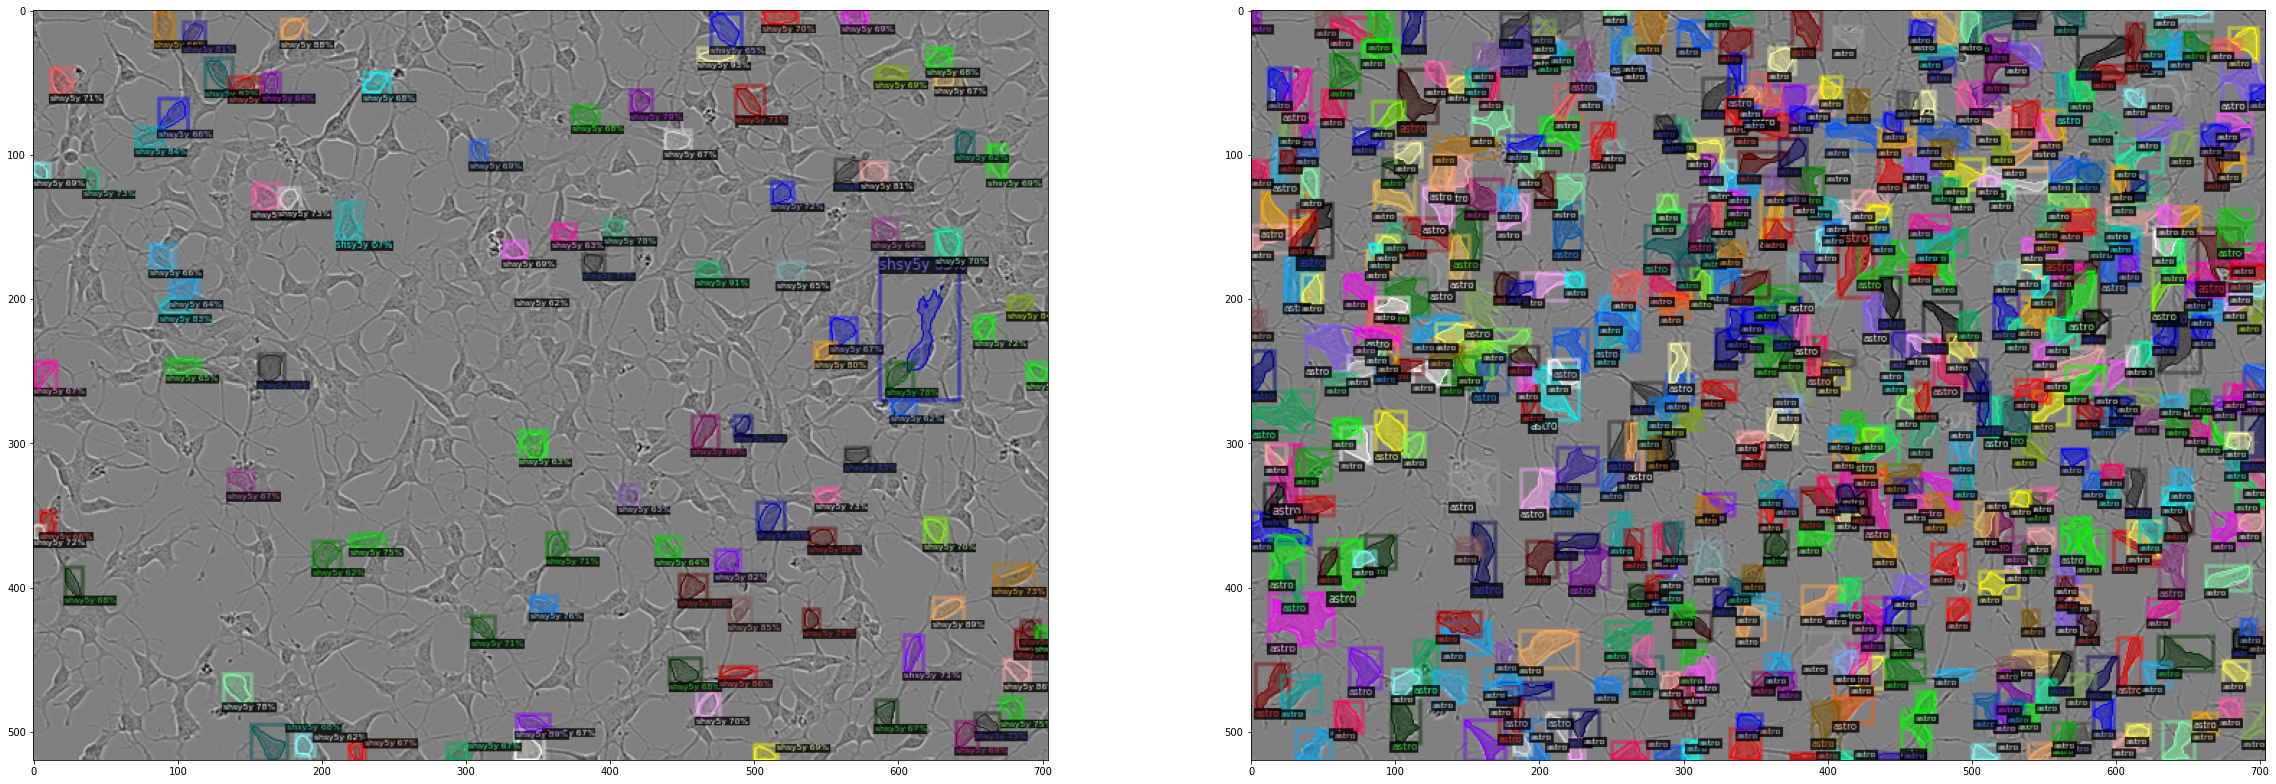

In [26]:
# classes = []
# c0 = random.sample([d for d in dataset_dicts if d['annotations'][0]['category_id'] == 0], 1)
# classes.append(c0[0])
# c1 = random.sample([d for d in dataset_dicts if d['annotations'][0]['category_id'] == 1], 1)
# classes.append(c1[0])
# c2 = random.sample([d for d in dataset_dicts if d['annotations'][0]['category_id'] == 2], 1)
# classes.append(c2[0])

cfg.MODEL.WEIGHTS = os.path.join('./output', 'model_best.pth')  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0  # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in [classes[2]]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

## Inference and submission

There are two minor details we need to handle:
- The submission notebooks don't have access to the internet, in order to install detectron2 I needed to download dependecies with `pip download`, put them into a dataset and attach it to the notebook: https://www.kaggle.com/slawekbiel/detectron-05
- The masks we submit can't overlap, see [the discussion](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790#1550666). So I'm manually clipping the output returned from the model) I'm processing the masks ordereded by score, so in the case of conflict the more confident one remaines whole and the other one gets clipped.

In [44]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [29]:
ids, masks=[],[]
# test_names = (dataDir/'test').ls()
PATHGLOB = Path(dataDir/'test').glob('./*')
test_names = [fil for fil in PATHGLOB]
test_names

[PosixPath('sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png'),
 PosixPath('sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png'),
 PosixPath('sartorius-cell-instance-segmentation/test/d48ec7815252.png')]

### Initiate a Predictor from our trained model

In [56]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('./output', "model_best.pth")  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.2, .0, .65]
MIN_PIXELS = [75, 150, 75]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

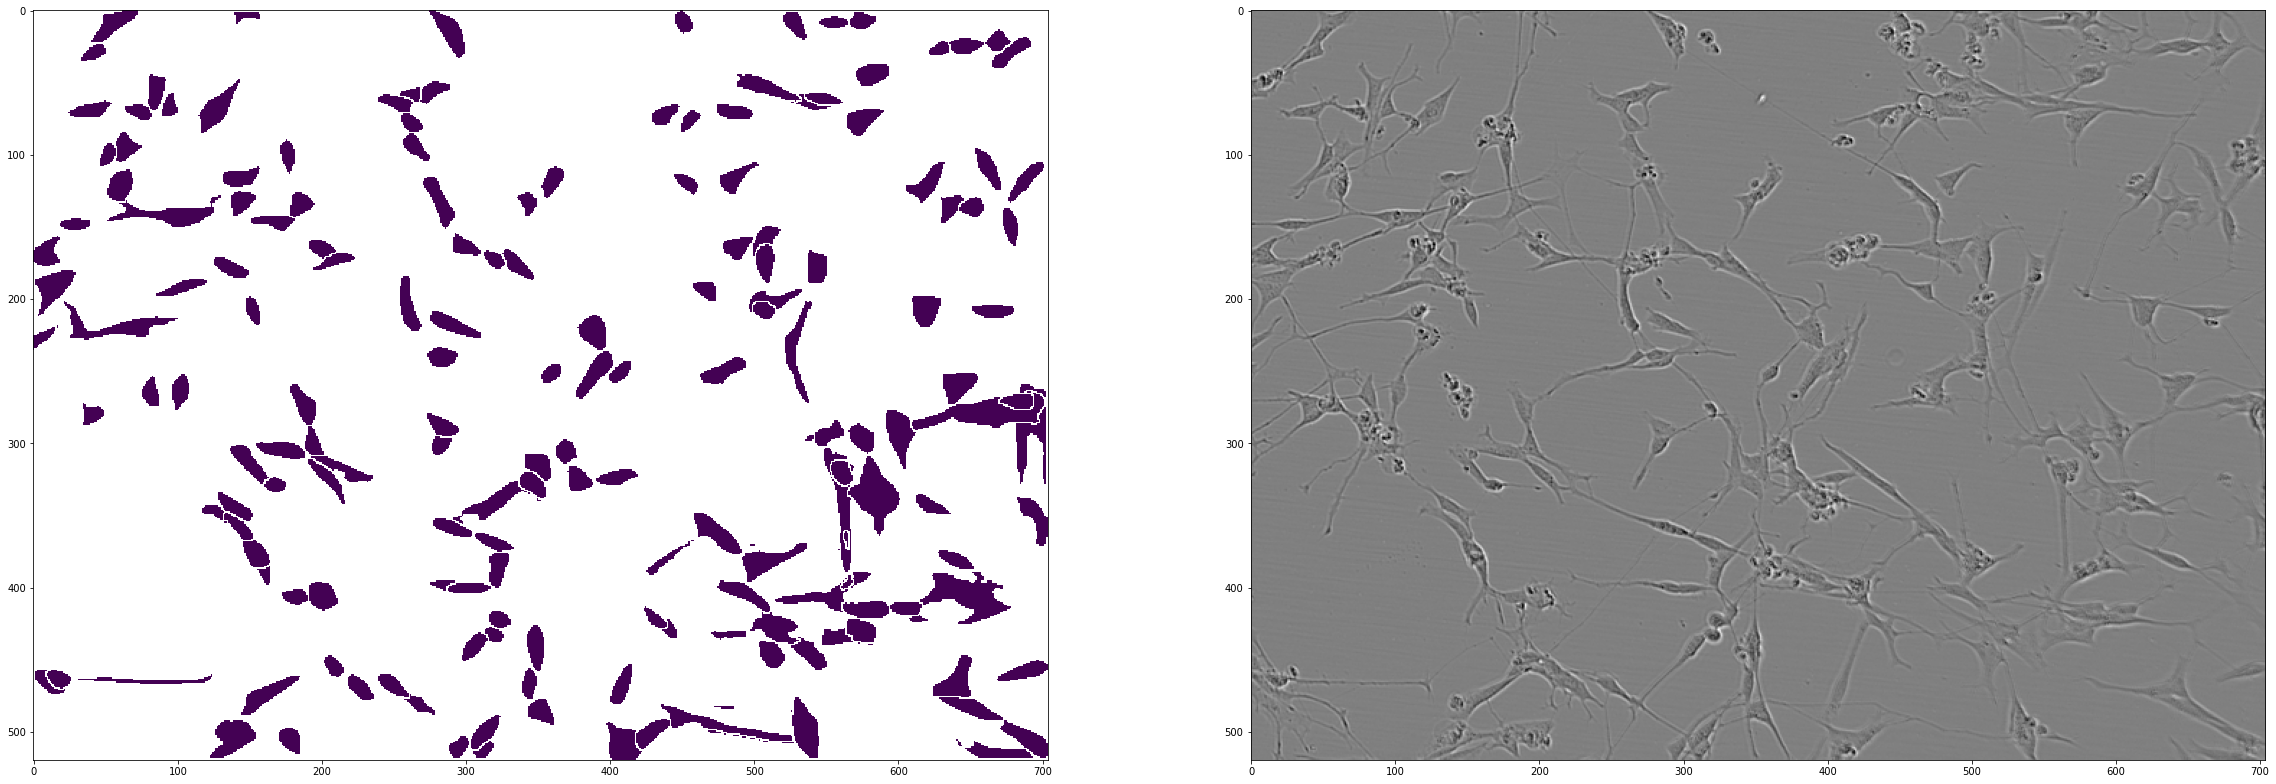

In [55]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

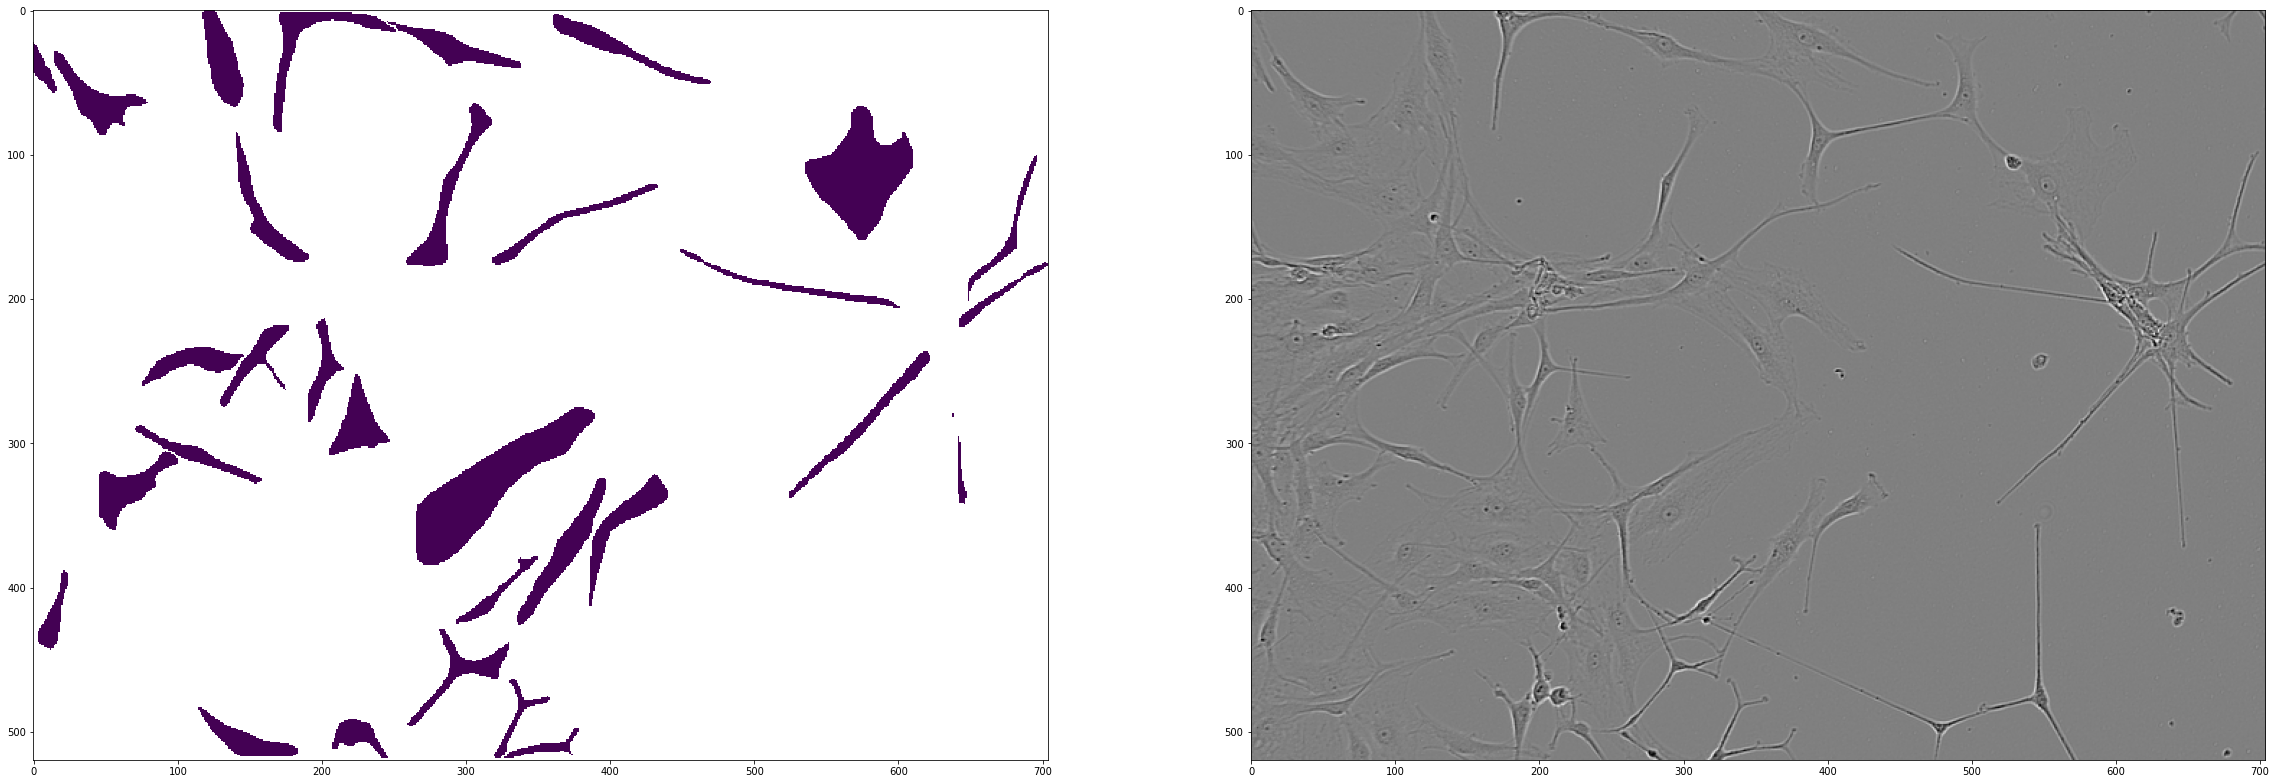

In [57]:
encoded_masks = get_masks(test_names[1], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[1])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

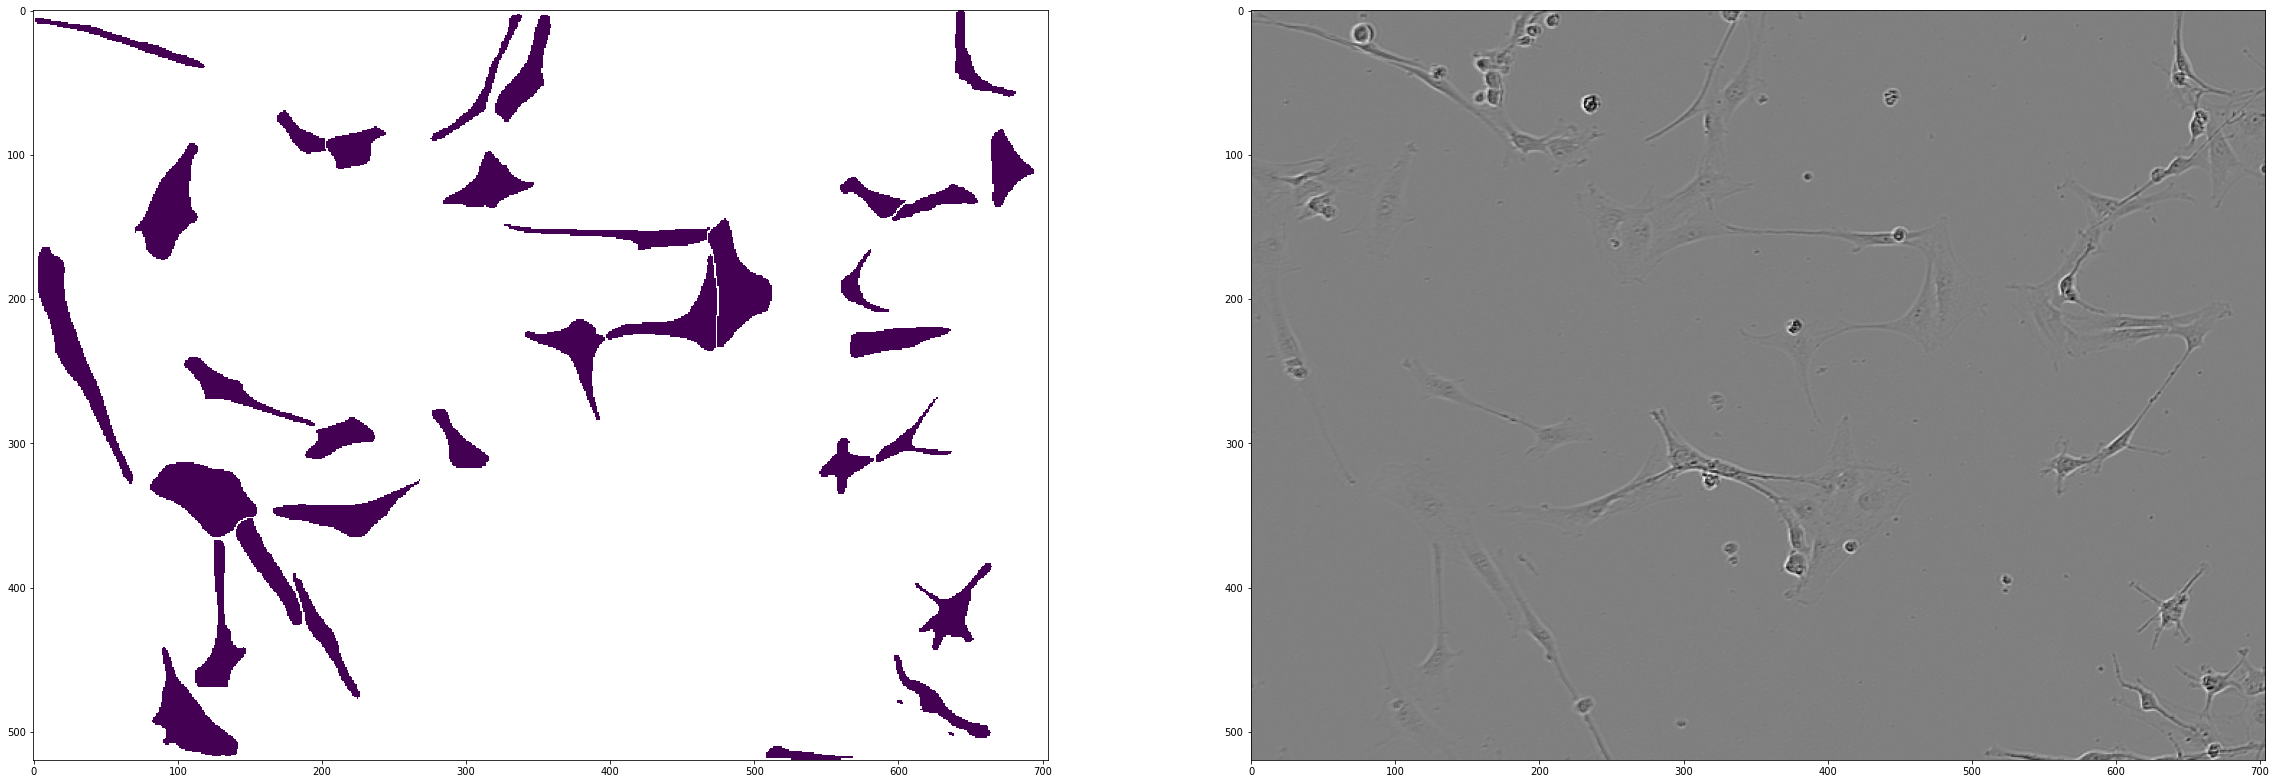

In [53]:
encoded_masks = get_masks(test_names[2], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[2])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

### Looks good, so lets generate masks for all the files and create a submission

In [22]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [23]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

id                                          predicted
0  7ae19de7bc2a  183221 4 183923 7 184627 8 185331 9 186035 10 ...
1  7ae19de7bc2a  353707 1 354409 5 355112 7 355814 9 356517 10 ...
2  7ae19de7bc2a  148229 3 148931 6 149633 9 150336 11 151039 13...
3  7ae19de7bc2a  26628 12 27329 17 28031 19 28734 21 29436 23 3...
4  7ae19de7bc2a  140003 15 140706 20 141410 21 142114 21 142818...